<a href="https://colab.research.google.com/github/Vaivaswat2244/Adobe-GenSolve/blob/main/Regularisation_and_Symmetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import random

In [3]:
from tqdm import tqdm

In [4]:
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


In [5]:
def read_csv(csv_path):
    np_path_XYs = np. genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np. unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np. unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs. append(XY)
        path_XYs . append(XYs)
    return path_XYs


def plot(csv_path):
    paths_XYs=read_csv(csv_path)
    file_name = csv_path.split("/")[-1]
    savepath = '{}.png'.format(file_name.split(".")[0])
    colours = ['b', 'g', 'r', 'c', 'y', 'k']
    fig, ax = plt.subplots(tight_layout=True, figsize =(8, 8))
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth =2)

    ax.set_aspect('equal')
    ax.axis('off')  # Turn off the axis
    plt.savefig(savepath, bbox_inches='tight', pad_inches=0)
    # plt.show()
    return  savepath

In [6]:
def thinning_iteration(img, iter):
    marker = np.zeros(img.shape, np.uint8)
    for i in range(1, img.shape[0] - 1):
        for j in range(1, img.shape[1] - 1):
            p2 = img[i-1, j]
            p3 = img[i-1, j+1]
            p4 = img[i, j+1]
            p5 = img[i+1, j+1]
            p6 = img[i+1, j]
            p7 = img[i+1, j-1]
            p8 = img[i, j-1]
            p9 = img[i-1, j-1]

            A = int((p2 == 0 and p3 == 1) + (p3 == 0 and p4 == 1) +
                    (p4 == 0 and p5 == 1) + (p5 == 0 and p6 == 1) +
                    (p6 == 0 and p7 == 1) + (p7 == 0 and p8 == 1) +
                    (p8 == 0 and p9 == 1) + (p9 == 0 and p2 == 1))
            B = int(p2 + p3 + p4 + p5 + p6 + p7 + p8 + p9)
            m1 = int(p2 * p4 * p6) if iter == 0 else int(p2 * p4 * p8)
            m2 = int(p4 * p6 * p8) if iter == 0 else int(p2 * p6 * p8)

            if A == 1 and (B >= 2 and B <= 6) and m1 == 0 and m2 == 0:
                marker[i, j] = 1

    img = cv2.bitwise_and(img, cv2.bitwise_not(marker))
    return img

def thinning(src):
    dst = src.copy().astype(np.uint8)
    prev = np.zeros(src.shape[:2], np.uint8)
    diff = None

    while True:
        dst = thinning_iteration(dst, 0)
        dst = thinning_iteration(dst, 1)
        diff = cv2.absdiff(dst, prev)
        prev = dst.copy()
        if np.sum(diff) == 0:
            break

    return dst



# **Shape Regularization**
The process involves the following key steps:
1.	Image Preprocessing:
o	Convert the input image to grayscale.
o	Apply binary thresholding to create a black and white image.
2.	Contour Detection:
o	Use OpenCV's findContours function to identify shapes in the binary image.
3.	Shape Classification:
o	For each contour, calculate circularity and detect corners.
o	Classify shapes based on these properties into categories such as circles, rectangles, triangles, pentagons, and stars.
4.	Shape Regularization:
o	Draw regularized versions of the detected shapes on a new image.
o	Use specific drawing methods for each shape type (e.g., cv2.circle for circles, cv2.rectangle for rectangles).
5.	Special Handling for Stars:
o	Implement a custom algorithm to detect and draw star shapes accurately.


In [7]:

def detect_corners(img, contour):
    # Create a mask for the contour
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [contour], 0, 255, -1)

    # Apply Harris Corner Detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)

    # Threshold for an optimal value, it may vary depending on the image
    corners = cv2.dilate(dst, None)
    _, corners = cv2.threshold(corners, 0.01 * corners.max(), 255, 0)
    corners = np.uint8(corners)

    # Apply the mask to get only corners within the contour
    corners = cv2.bitwise_and(corners, corners, mask=mask)

    # Get corner coordinates
    corner_coords = cv2.goodFeaturesToTrack(corners, 20, 0.01, 10)

    if corner_coords is not None:
        corner_coords = np.int0(corner_coords)
        corner_coords = [c[0] for c in corner_coords]
    else:
        corner_coords = []

    return corner_coords

def detect_shape(img, contour):
    # Compute circularity
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    circularity = (4 * np.pi * area) / (perimeter * perimeter)

    # Approximate the contour
    epsilon = 0.02 * perimeter
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Detect corners
    corners = detect_corners(img, contour)
    num_corners = max(len(approx), len(corners))

    if circularity > 0.9:
        return "CIRCLE", []
    elif circularity > 0.75 and 4 <= num_corners <= 6:
        return "RECTANGLE", approx
    elif 0.6 < circularity < 0.8 and 3 <= num_corners <= 4:
        return "TRIANGLE", approx
    elif 0.6 < circularity < 0.8 and 5 <= num_corners <= 6:
        return "PENTAGON", approx
    elif 0.4 < circularity < 0.6 and 8 <= num_corners <= 12:
        return "STAR", corners
    else:
        return "UNKNOWN", []

Rectangle (or square) detected
Retangle (or square) regularised
Rectangle (or square) detected
Retangle (or square) regularised
Rectangle (or square) detected
Retangle (or square) regularised
Star Detected
Star regularised
Star Detected
Star regularised
Circle Detected
Circle Regularised
Circle Detected
Circle Regularised


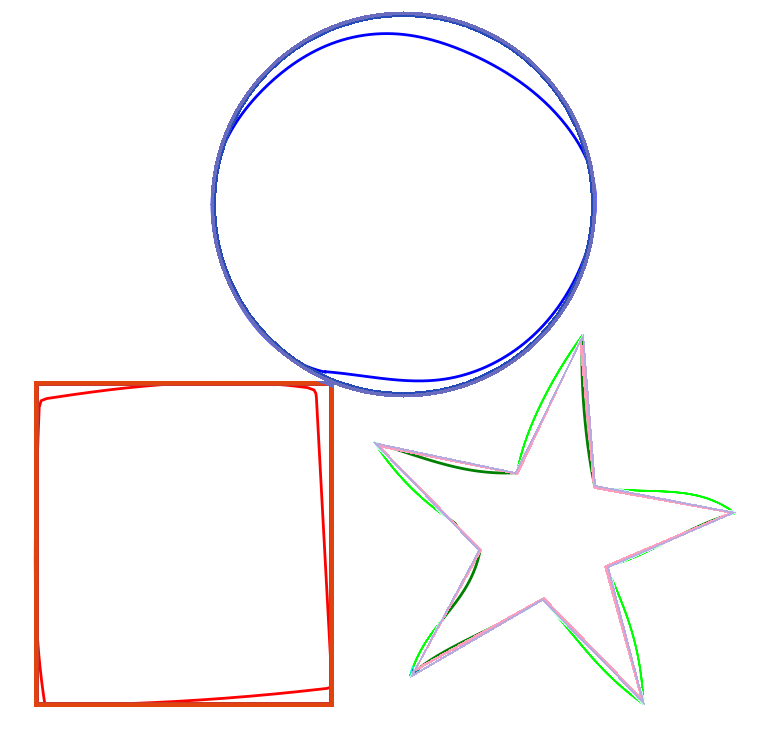

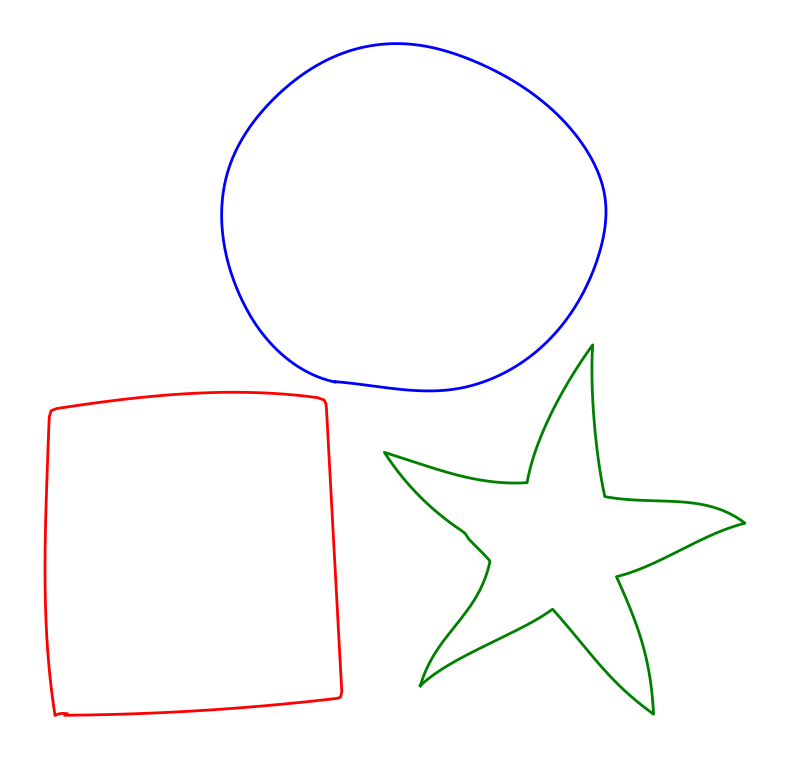

In [16]:
src_path = '/content/drive/MyDrive/Input/problems/isolated.csv'# Add Path to the csv file
src = cv2.imread(plot(src_path))# add Path to the csv file

# Convert to grayscale
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

# Binarize
_, bin = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

#Perform Thinning
# bin = thinning(bin)

# Create result image
res = src.copy()

# Create a mask for regularized shapes
mask = np.zeros(src.shape[:2], dtype=np.uint8)

# Find contours
contours, _ = cv2.findContours(bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# print(len(contours))
# For each contour
for contour in contours:
    # Compute convex hull
    hull = cv2.convexHull(contour)

    # Compute circularity, used for shape classification
    area = cv2.contourArea(hull)
    perimeter = cv2.arcLength(hull, True)

    if perimeter != 0:
        circularity = (4 * np.pi * area) / (perimeter * perimeter)
    else:
        circularity = 0

    # Shape classification
    color = tuple(random.randint(0, 255) for _ in range(3))

    # Check for star shape
    ratio = np.sqrt(cv2.contourArea(contour)) / cv2.arcLength(contour, True)
    if 0.125 < ratio < 0.175:
        vertices = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)
        if len(vertices) == 5:
            # PENTAGON
            print("Pentagon Detected")
            (x, y), radius = cv2.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)
            new_img = np.zeros_like(src)
            pts = []
            for j in range(5):
                angle = j * 2 * np.pi / 5
                x = center[0] + radius * np.cos(angle)
                y = center[1] + radius * np.sin(angle)
                pts.append((int(x), int(y)))
            pts = np.array([pts], dtype=np.int32)
            cv2.drawContours(new_img, [pts], 0, color, 2)
            star_mask = new_img[:, :, 0] > 0
            res[star_mask] = new_img[star_mask]
            cv2.drawContours(mask, [pts], 0, 255, -1)
            print("Pentagon Regularised")
        else:
            # STAR
            print("Star Detected")
            for j in range(len(vertices)):
                pt1 = tuple(vertices[j][0])
                pt2 = tuple(vertices[(j+1) % len(vertices)][0])
                cv2.line(res, pt1, pt2, color, 2)
            cv2.drawContours(mask, [vertices], 0, 255, -1)
            print("Star regularised")


    elif circularity > 0.9:
        # CIRCLE
        print("Circle Detected")
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(res, center, radius, color, 5)
        cv2.circle(mask, center, radius, 255, -1)
        print("Circle Regularised")

    elif circularity > 0.75:
        # RECTANGLE
        print("Rectangle (or square) detected")
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(res, (x, y), (x+w, y+h), color, 5)
        cv2.rectangle(mask, (x, y), (x+w, y+h), 255, -1)
        print("Retangle (or square) regularised")

    elif circularity > 0.7:
        # TRIANGLE
        print("Triangle detected")
        roi = cv2.boundingRect(contour)
        mask_roi = np.zeros(bin.shape, dtype=np.uint8)
        cv2.rectangle(mask_roi, (roi[0], roi[1]), (roi[0]+roi[2], roi[1]+roi[3]), 255, -1)
        triangle = cv2.bitwise_and(bin, bin, mask=mask_roi)

        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))

        vertices = []
        while len(vertices) < 3:
            radius -= 1
            mask_circ = np.zeros(bin.shape, dtype=np.uint8)
            cv2.circle(mask_circ, center, int(radius), 255, 5)
            mask_circ = cv2.bitwise_and(mask_circ, triangle)
            vertices, _ = cv2.findContours(mask_circ, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

        cv2.line(res, tuple(vertices[0][0][0]), tuple(vertices[1][0][0]), color, 5)
        cv2.line(res, tuple(vertices[1][0][0]), tuple(vertices[2][0][0]), color, 5)
        cv2.line(res, tuple(vertices[2][0][0]), tuple(vertices[0][0][0]), color, 5)
        cv2.drawContours(mask, [vertices], 0, 255, -1)
        print("Triangle regularised")
    else:
        print("unknown shape, No regularisation")
        # Unrecognized shape, draw as is
        cv2.drawContours(res, [contour], 0, color, 2)
        cv2.drawContours(mask, [contour], 0, 255, -1)

# Invert the mask
mask_inv = cv2.bitwise_not(mask)

# Remove regularized shapes from the original image
src_no_regular = cv2.bitwise_and(src, src, mask=mask_inv)

# Combine the result image with the original image without regularized shapes
final_result = cv2.add(res, src_no_regular)

cv2_imshow( final_result)
cv2.imwrite('final_result.png',final_result)
cv2.waitKey(0)
cv2.destroyAllWindows()

# **Line detection and Regularisation**
The line smoothening process includes:

Edge Detection: o Apply Canny edge detection to identify edges in the image.

Hough Line Transform: o Use the probabilistic Hough Line Transform (cv2.HoughLinesP) to detect line segments in the edge image.

Line Drawing: o Create a blank white canvas. o Draw the detected lines on this canvas, resulting in a cleaner representation of the linear features.

### ***Note:***
Use This algorithm only when there are no regular shape and the doodle contains just the lines (like a mesh, chessboard etc.) as it just changes the hand drawn lines to straight lines and if you apply it on a curves shape like circle, it would return just the same shape but with corners.


like the shape given below

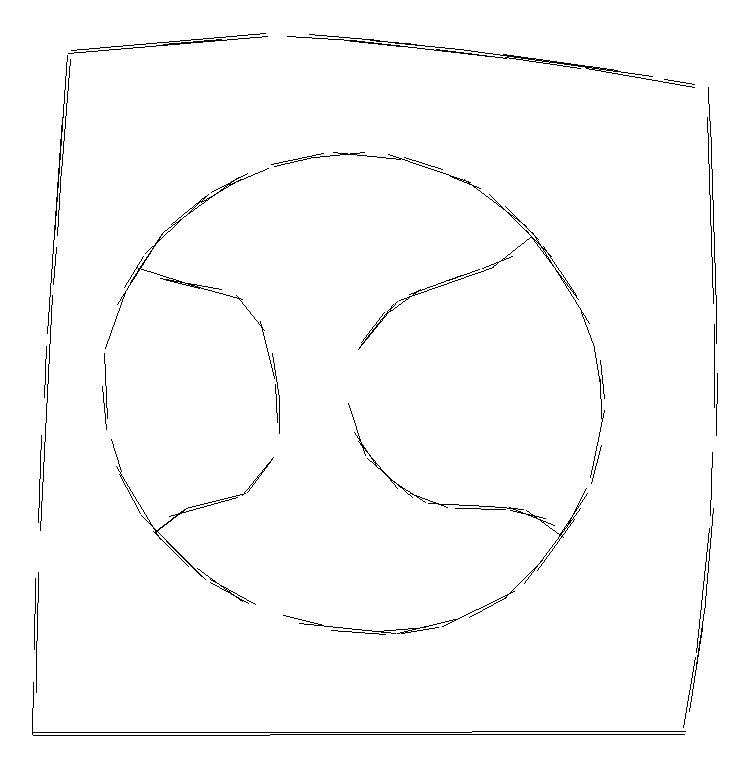

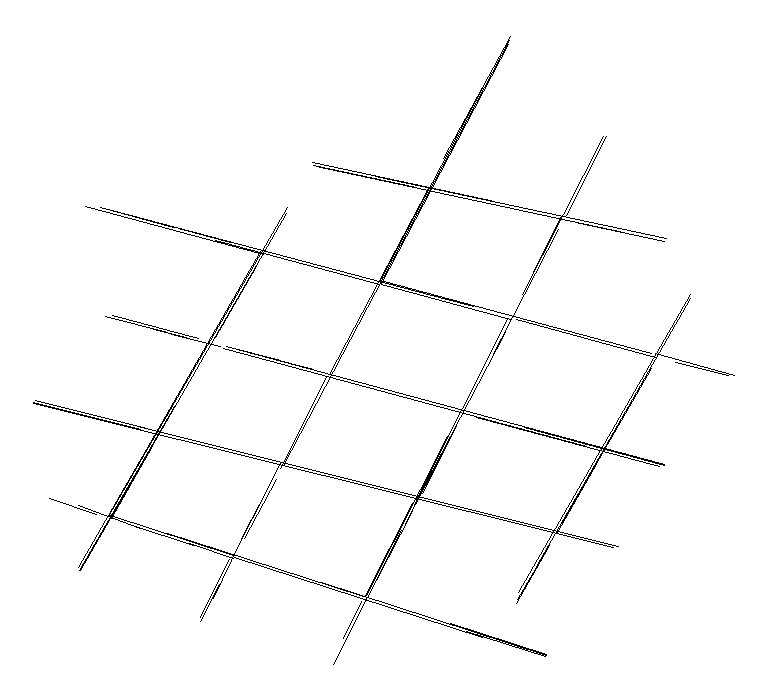

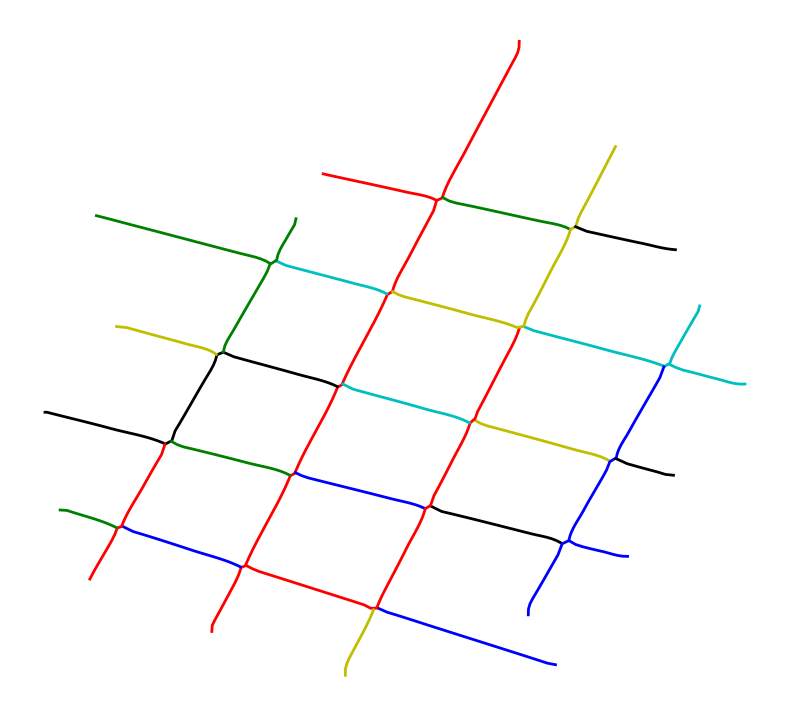

In [12]:
import cv2
import numpy as np

def detect_lines(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=30, minLineLength=30, maxLineGap=10)
    return lines

def regularize_shapes(image):
    # Detect lines
    lines = detect_lines(image)

    # Create a white canvas
    canvas = np.ones_like(image) * 255

    # Draw detected lines on the white canvas
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(canvas, (x1, y1), (x2, y2), (0, 0, 0), 1)

    return canvas

# Load the image
original_img_path = '/content/drive/MyDrive/Input/problems/frag2.csv'# Add path to the CSV file
original_img = cv2.imread(plot(original_img_path))

# Apply regularization
regularized_img = regularize_shapes(original_img)

# Display the result
cv2_imshow(regularized_img)
cv2.imwrite('regularized_shapes.png', regularized_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# **Symmetry Detection**
The line smoothening process includes:
1.	Edge Detection:
o	Apply Canny edge detection to identify edges in the image.
2.	Hough Line Transform:
o	Use the probabilistic Hough Line Transform (cv2.HoughLinesP) to detect line segments in the edge image.
3.	Line Drawing:
o	Create a blank white canvas.
o	Draw the detected lines on this canvas, resulting in a cleaner representation of the linear features.


The image is symmetric, the line of symmetry has r=384.75 and theta=1.35


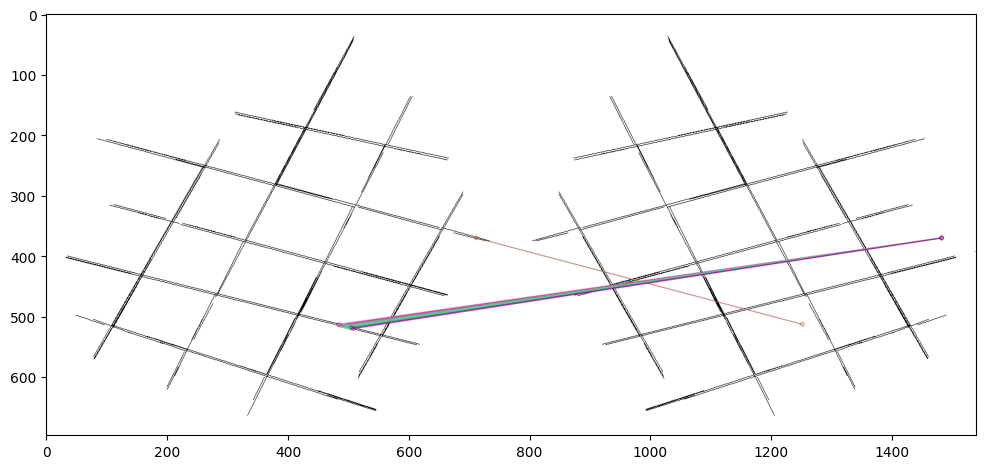

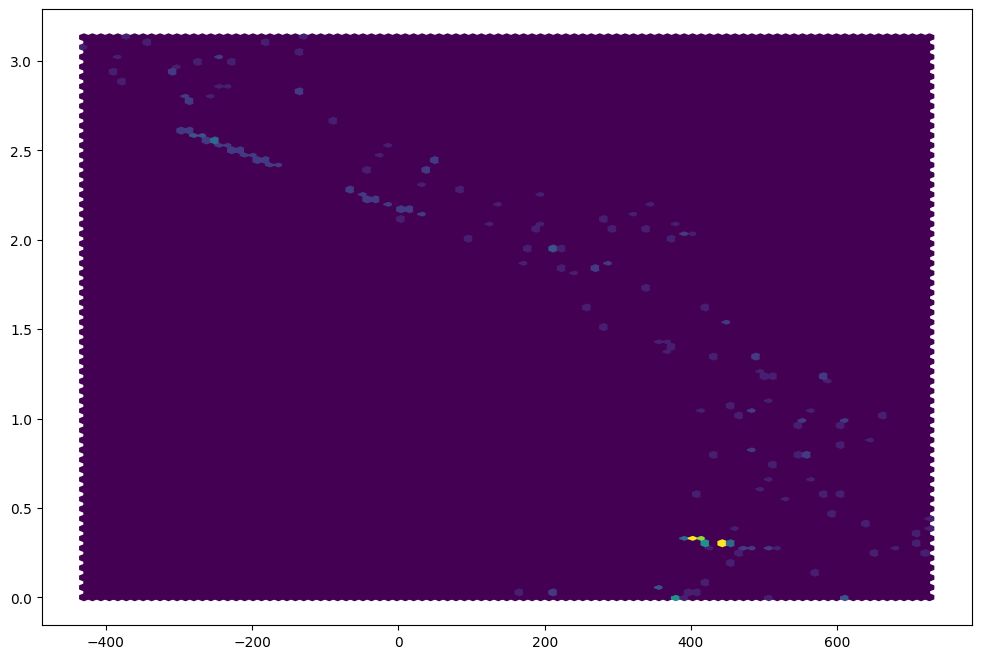

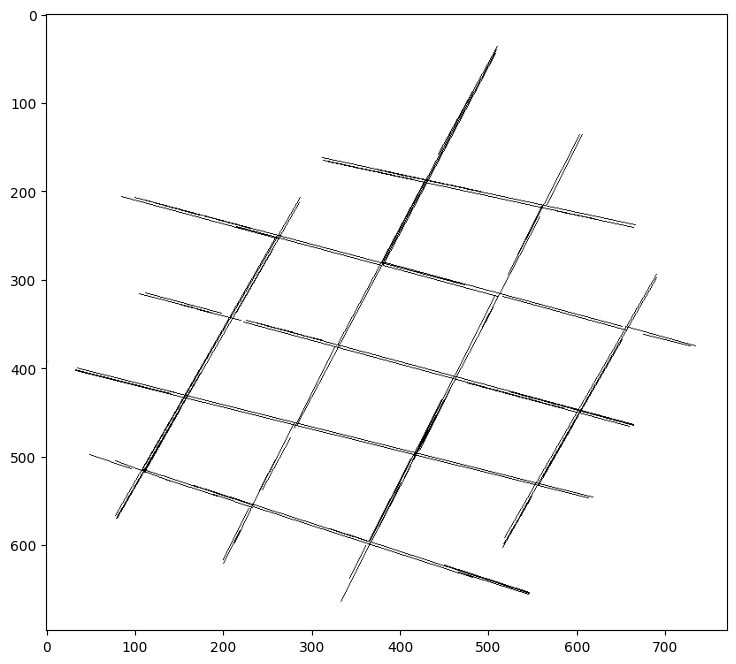

In [13]:
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Initialize SIFT (Scale-Invariant Feature Transform) detector
sift = cv2.xfeatures2d.SIFT_create()

def very_close(a, b, tol=4.0):
    """Checks if the points a, b are within tol distance of each other."""
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) < tol

def S(si, sj, sigma=1):
    """Computes the 'S' function mentioned in the research paper."""
    q = (-abs(si - sj)) / (sigma * (si + sj))
    return np.exp(q ** 2)

def reisfeld(phi, phj, theta):
    """Computes the Reisfeld symmetry measure."""
    return 1 - np.cos(phi + phj - 2 * theta)

def midpoint(i, j):
    """Calculates the midpoint between two points."""
    return (i[0] + j[0]) / 2, (i[1] + j[1]) / 2

def angle_with_x_axis(i, j):
    """Calculates the angle between the line joining two points and the x-axis."""
    x, y = i[0] - j[0], i[1] - j[1]
    if x == 0:
        return np.pi / 2
    angle = np.arctan(y / x)
    if angle < 0:
        angle += np.pi
    return angle

def draw_line_of_symmetry(image, r, theta):
    """Draws the line of symmetry on the image."""
    if np.pi / 4 < theta < 3 * (np.pi / 4):
        for x in range(len(image.T)):
            y = int((r - x * np.cos(theta)) / np.sin(theta))
            if 0 <= y < len(image.T[x]):
                image[y][x] = (0, 255, 0)  # Set the pixel to green
    else:
        for y in range(len(image)):
            x = int((r - y * np.sin(theta)) / np.cos(theta))
            if 0 <= x < len(image[y]):
                image[y][x] = (0, 255, 0)  # Set the pixel to green

def superm2(image):
    """Performs the symmetry detection on image."""
    # Create a mirrored version of the image
    mimage = np.fliplr(image)

    # Detect SIFT features and compute descriptors for both images
    kp1, des1 = sift.detectAndCompute(image, None)
    kp2, des2 = sift.detectAndCompute(mimage, None)

    # Convert keypoint angles to radians
    for p, mp in zip(kp1, kp2):
        p.angle = np.deg2rad(p.angle)
        mp.angle = np.deg2rad(mp.angle)

    # Use BruteForce matcher to find matching keypoints
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Initialize arrays for Hough transform
    houghr = np.zeros(len(matches))
    houghth = np.zeros(len(matches))
    weights = np.zeros(len(matches))

    i = 0
    good = []
    for match, match2 in matches:
        point = kp1[match.queryIdx]
        mirpoint = kp2[match.trainIdx]
        mirpoint2 = kp2[match.trainIdx]

        # Adjust angles of mirrored points
        mirpoint2.angle = np.pi - mirpoint2.angle
        mirpoint.angle = np.pi - mirpoint.angle
        if mirpoint.angle < 0.0:
            mirpoint.angle += 2 * np.pi
        if mirpoint2.angle < 0.0:
            mirpoint2.angle += 2 * np.pi

        # Adjust coordinates of mirrored point
        mirpoint.pt = (mimage.shape[1] - mirpoint.pt[0], mirpoint.pt[1])

        # Choose the better match
        if very_close(point.pt, mirpoint.pt):
            mirpoint = mirpoint2
            good.append(match2)
        else:
            good.append(match)

        # Calculate parameters for Hough transform
        theta = angle_with_x_axis(point.pt, mirpoint.pt)
        xc, yc = midpoint(point.pt, mirpoint.pt)
        r = xc * np.cos(theta) + yc * np.sin(theta)

        # Calculate symmetry measure
        Mij = reisfeld(point.angle, mirpoint.angle, theta) * S(
            point.size, mirpoint.size
        )

        # Store Hough transform parameters and weights
        houghr[i] = r
        houghth[i] = theta
        weights[i] = Mij
        i += 1

    # Sort good matches by distance
    good = sorted(good, key=lambda x: x.distance)

    # Check if the image is symmetric
    is_symmetric = len(good) >= 15
    if is_symmetric:
        # Find the dominant line of symmetry
        best_r = np.median(houghr)
        best_theta = np.median(houghth)
        print(f"The image is symmetric, the line of symmetry has r={best_r:.2f} and theta={best_theta:.2f}")
        draw_line_of_symmetry(image, best_r, best_theta)
    else:
        print("The image is not symmetric")

    # Draw matches between original and mirrored image
    img3 = cv2.drawMatches(image, kp1, mimage, kp2, good[:15], None, flags=2)
    plt.figure(figsize=(12, 8))
    plt.imshow(img3)
    plt.show()

    # Plot Hough transform results
    plt.figure(figsize=(12, 8))
    plt.hexbin(houghr, houghth, bins=200)
    plt.show()

    # If symmetric, show the image with the line of symmetry
    if is_symmetric:
        plt.figure(figsize=(12, 8))
        plt.imshow(image, cmap='gray')
        plt.show()

# Read the image and perform symmetry detection
image = cv2.imread('/content/regularized_shapes.png', cv2.IMREAD_COLOR)
superm2(image)